# Practical Session on Graph Neural Networks

**by Matthieu Nastorg and Cyriaque Rousselot**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric

### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [2]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning). 

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [10]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Number of nodes in the sample from the train dataset: ", len(train_dataset[0].x))
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Number of nodes in the sample from the train dataset:  1767
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121

Device:  cuda


Each node is defined by 50 features.

### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [4]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)
        return x

Next we construct the function to train the model.

In [5]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [6]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device) #Convert to device
        output = model(batch.x, batch.edge_index) #Forward pass
        loss_test = loss_fcn(output, batch.y) #compute the loss
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0) #Classification prediction
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro") #
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [15]:
### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(
    input_size=n_features, hidden_size=256, output_size=n_classes
).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)

Epoch 00001 | Loss: 0.6366
F1-Score: 0.4517
Epoch 00002 | Loss: 0.5802
Epoch 00003 | Loss: 0.5615
Epoch 00004 | Loss: 0.5560
Epoch 00005 | Loss: 0.5506
Epoch 00006 | Loss: 0.5461
F1-Score: 0.5043
Epoch 00007 | Loss: 0.5421
Epoch 00008 | Loss: 0.5378
Epoch 00009 | Loss: 0.5341
Epoch 00010 | Loss: 0.5314
Epoch 00011 | Loss: 0.5288
F1-Score: 0.5235
Epoch 00012 | Loss: 0.5261
Epoch 00013 | Loss: 0.5236
Epoch 00014 | Loss: 0.5212
Epoch 00015 | Loss: 0.5188
Epoch 00016 | Loss: 0.5167
F1-Score: 0.5356
Epoch 00017 | Loss: 0.5145
Epoch 00018 | Loss: 0.5124
Epoch 00019 | Loss: 0.5104
Epoch 00020 | Loss: 0.5084
Epoch 00021 | Loss: 0.5066
F1-Score: 0.5325
Epoch 00022 | Loss: 0.5048
Epoch 00023 | Loss: 0.5031
Epoch 00024 | Loss: 0.5015
Epoch 00025 | Loss: 0.4993
Epoch 00026 | Loss: 0.4972
F1-Score: 0.5264
Epoch 00027 | Loss: 0.4953
Epoch 00028 | Loss: 0.4934
Epoch 00029 | Loss: 0.4916
Epoch 00030 | Loss: 0.4897
Epoch 00031 | Loss: 0.4877
F1-Score: 0.5491
Epoch 00032 | Loss: 0.4860
Epoch 00033 | Los

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6547


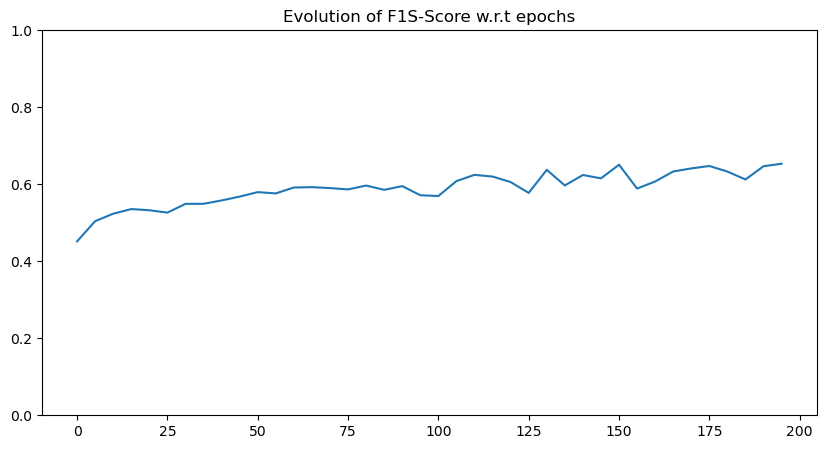

In [17]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

# Graph Convolutional Layer

Define the adjacency matrix $A$ of a graph: 
$$
A_{i,j} = 
\left\{
\begin{array}{lc}
1 \, \text{if node i and j are adjacents} \\
0 \, \text{else}
\end{array}
\right.
$$
and the degree matrix:
$$
D_{i,j} = 
\left\{
\begin{array}{lc}
\frac{1}{\sqrt{d_{i,i}}}\, \text{if i=j} \\
0 \, \text{else}
\end{array}
\right.
$$
where $d_{i,i}$ is the degree of node $i$. The set of node in the graph is noted $X \in \mathbb{R}^{N\times D}$, with $N$ is the number of nodes and $D$ its set of features. 
Normalize the adjacency matrix $A$ via $\tilde{A} = D^{-\frac{1}{2}}(A + I)D^{-\frac{1}{2}}$ and introduce a learnable weight matrix $W \in \mathbb{R}^{D \times D^{'}}$, $\textbf{common}$ to all nodes but attached to this layer. $D^{'}$ is the number of features in the latent space.
The forward pass of the convolutional layer is: $f(X,A) = \sigma(\tilde{A}XW)$. There exists some variant of $\tilde{A}$, depending the normalization factor' choice. Above, this coefficient is $\frac{1}{\sqrt{d_id_j}}$, because, writing $\tilde{A}$ explicitely yields:
$$
\tilde{A}X = \sum_{j \in \mathcal{N}(i)}\frac{x_j}{\sqrt{d_id_j}}.
$$
Here, $\mathcal{N}(i)$ denotes the set of adjacent nodes of $i$. Note that $i$ is adjacent to itself.

# Graph Attentional Layer
**HINT :** https://arxiv.org/pdf/1710.10903.pdf

According to this article, to define a graph attention networks, we have to implement a self-attention like mechanism. It goes through by defining a weight matrix $W \in \mathbb{R}^{F \times F'}$, where $F$ is the number of features of the nodes (they all have the same number of features), and $F'$ the size of the embedding. By multiplying every node's feature by the same weight matrix $W$, one built the matrix attention with the help of an additional parameter $a \in \mathbb{R}^{2F'}$:
$$
e_{i,j} = a^{T}(Wh_i||Wh_j),
$$
where for each node $i$, $j \in \mathcal{N}(i)$.
We then apply an activation function with a soft-max normalization step:
$$
\alpha_{i,j} = \text{SoftMax}(\sigma_b(e_{i,j})),
$$
where $||$ refers to the concatenation operator and the softmax is over all neighbour nodes $j \in \mathcal{N}(i)$. In this report, one will use $\sigma_b(x) = \text{LeakyReLU}(x) = \text{max}(x,0) + \beta\min(0,x)$, with $\beta = 0.02$.

Once these coefficients are computed, we can start acting on this latent space.
We will define for node $i$ its output $h_i^{'}$ through the neural network by:
$$
h'_i = \sigma\bigg(\sum_{j\in \mathcal{N}_i}\alpha_{i,j}Wh_j\bigg),
$$

or its multi-head version, for all $k \in \{1, \cdots K\}$:
$$
h^{'}_i = \overset{K}{\underset{k = 1}{\bigg|\bigg|}}\sigma\bigg(\sum_{j\in \mathcal{N}_i}^k\alpha_{i,j}W^kh_j\bigg).
$$
Here, the concatenation operator breaks the permutation invariant property, so one rather employes an averaging operator:
$$
h^{'}_i = \sigma\bigg(\frac{1}{K}\sum_{k = 1}^K\sum_{j\in \mathcal{N}_i}\alpha_{i,j}^kW^kh_j\bigg).
$$

### Transductive learning

In [69]:
# class GraphAttentionalLayer(nn.Module):
#   def __init__(self, input_size, hidden_size, activation, K):
#     super().__init__()

#     self.input_size = input_size
#     self.hidden_size = hidden_size
#     self.K = K

#     self.weight_K = torch.nn.ModuleList([torch.nn.Linear(input_size, hidden_size, bias = False, device=device) for _ in range(K)])
#     self.a_K = torch.nn.ModuleList([torch.nn.Linear(2*hidden_size,1, bias = False, device=device) for _ in range(K)])
#     self.activation = activation
#     self.leaky = torch.nn.LeakyReLU(negative_slope=0.02)
#     self.softmax = torch.nn.Softmax(dim=0)

#   def forward(self, x, edge_index):
#     out = torch.zeros((len(x), self.hidden_size), device=device)
#     for id_x in range(len(x)):
#       idx_neighbours = edge_index[1][edge_index[0] == id_x]
#       for k in range(self.K):
#         H1 = self.weight_K[k](x[id_x])[None,:]
#         H1 = H1.expand(len(idx_neighbours), self.hidden_size).to(device) #To concatenate it with all its neighbours
#         H2 = self.weight_K[k](x[idx_neighbours]).to(device)
#         a = self.a_K[k]
#         H = torch.concat((H1,H2), axis = 1).to(device)
#         embedd = self.softmax(self.leaky(a(H))).flatten()
#         out[id_x] += 1/self.K*embedd@H2

#     return self.activation(out)

class StudentModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
      """Initialization of the neural network and definition of its parameters. 
         Args:
            - input_size = Number of features per node
            - hidden_size = Number of features in latent space
            - output_size = Number of classes
            - Initialization of layers' weights
      """
      super().__init__()
      
      self.first_layer = graphnn.GATConv(input_size, hidden_size, dropout = .6, heads = 8)
      self.activation1 = torch.nn.ELU()
      self.second_layer = graphnn.GATConv(hidden_size*8, output_size, dropout = .6, heads = 1, concat=False)

  def forward(self, x, edge_index):
    out = self.first_layer(x, edge_index)
    out = self.activation1(out)
    
    out = self.second_layer(out, edge_index)
    return out

Let's train your model !

In [70]:
## Student model
student_model = StudentModel(n_features, 8, n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005, weight_decay = 5e-3)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.6702
F1-Score: 0.3956
Epoch 00002 | Loss: 0.5975
Epoch 00003 | Loss: 0.5814
Epoch 00004 | Loss: 0.5809
Epoch 00005 | Loss: 0.5812
Epoch 00006 | Loss: 0.5798
F1-Score: 0.3996
Epoch 00007 | Loss: 0.5791
Epoch 00008 | Loss: 0.5787
Epoch 00009 | Loss: 0.5787
Epoch 00010 | Loss: 0.5792
Epoch 00011 | Loss: 0.5804
F1-Score: 0.4026
Epoch 00012 | Loss: 0.5794
Epoch 00013 | Loss: 0.5796
Epoch 00014 | Loss: 0.5801
Epoch 00015 | Loss: 0.5784
Epoch 00016 | Loss: 0.5794
F1-Score: 0.3959
Epoch 00017 | Loss: 0.5807
Epoch 00018 | Loss: 0.5788
Epoch 00019 | Loss: 0.5788
Epoch 00020 | Loss: 0.5802
Epoch 00021 | Loss: 0.5788
F1-Score: 0.3975
Epoch 00022 | Loss: 0.5787
Epoch 00023 | Loss: 0.5797
Epoch 00024 | Loss: 0.5791
Epoch 00025 | Loss: 0.5790
Epoch 00026 | Loss: 0.5795
F1-Score: 0.4022
Epoch 00027 | Loss: 0.5789
Epoch 00028 | Loss: 0.5791
Epoch 00029 | Loss: 0.5789
Epoch 00030 | Loss: 0.5797
Epoch 00031 | Loss: 0.5783
F1-Score: 0.3992
Epoch 00032 | Loss: 0.5788
Epoch 00033 | Los

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.3938


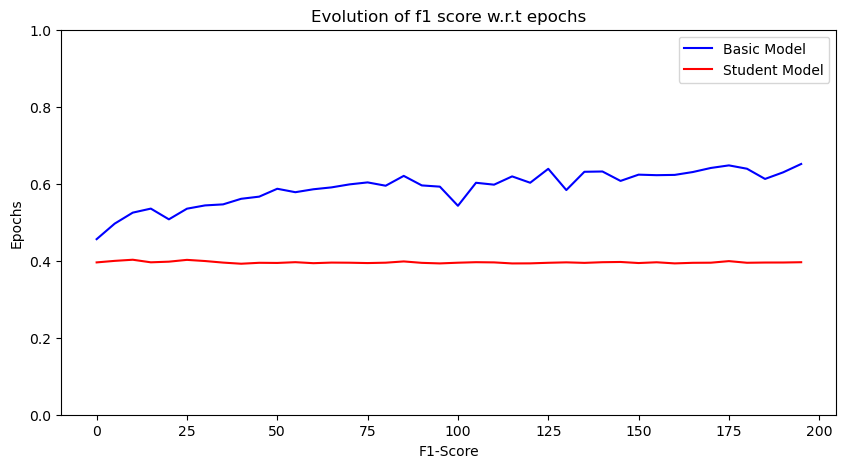

In [71]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

It does not work at all, this architecture is too simple to make inference on the nodes' labels.

### Inductive learning

This architecture uses 3 concatenated GAT layers, with respectively $4, 4$ and $6$ multi-head attention.

In [7]:
class StudentModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
      """Initialization of the neural network and definition of its parameters. 
         Args:
            - input_size = Number of features per node
            - hidden_size = Number of features in latent space
            - output_size = Number of classes
            - Initialization of layers' weights
      """
      super().__init__()

      self.linear1 = torch.nn.Linear(input_size, 4*hidden_size)
      self.linear2 = torch.nn.Linear(4*hidden_size, 4*hidden_size)

      self.first_layer = graphnn.GATConv(input_size, hidden_size, heads = 4)

      self.activation = torch.nn.ELU()

      self.second_layer = graphnn.GATConv(hidden_size*4, hidden_size, heads = 4)

      self.third_layer = graphnn.GATConv(4*hidden_size, output_size, heads = 6, concat=False)

  def forward(self, x, edge_index):
    out = self.first_layer(x, edge_index) + self.linear1(x)
    out = self.activation(out)
    out = self.second_layer(out, edge_index) + self.linear2(out)
    out = self.activation(out)
    out = self.third_layer(out, edge_index)
    return out

In [13]:
## Student model
student_model = StudentModel(n_features, 256, n_classes).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.7065
F1-Score: 0.4045
Epoch 00002 | Loss: 0.5568
Epoch 00003 | Loss: 0.5316
Epoch 00004 | Loss: 0.5125
Epoch 00005 | Loss: 0.4965
Epoch 00006 | Loss: 0.4824
F1-Score: 0.5425
Epoch 00007 | Loss: 0.4674
Epoch 00008 | Loss: 0.4533
Epoch 00009 | Loss: 0.4422
Epoch 00010 | Loss: 0.4292
Epoch 00011 | Loss: 0.4212
F1-Score: 0.6576
Epoch 00012 | Loss: 0.4065
Epoch 00013 | Loss: 0.3854
Epoch 00014 | Loss: 0.3690
Epoch 00015 | Loss: 0.3545
Epoch 00016 | Loss: 0.3429
F1-Score: 0.7238
Epoch 00017 | Loss: 0.3318
Epoch 00018 | Loss: 0.3160
Epoch 00019 | Loss: 0.3128
Epoch 00020 | Loss: 0.2975
Epoch 00021 | Loss: 0.2836
F1-Score: 0.7679
Epoch 00022 | Loss: 0.2693
Epoch 00023 | Loss: 0.2582
Epoch 00024 | Loss: 0.2466
Epoch 00025 | Loss: 0.2364
Epoch 00026 | Loss: 0.2279
F1-Score: 0.8126
Epoch 00027 | Loss: 0.2250
Epoch 00028 | Loss: 0.2164
Epoch 00029 | Loss: 0.2060
Epoch 00030 | Loss: 0.1973
Epoch 00031 | Loss: 0.1896
F1-Score: 0.8463
Epoch 00032 | Loss: 0.1844
Epoch 00033 | Los

This is computationally very heavy for my computer, because of the multi-head attention, the time complexity scales as: $\mathcal{O}(K|V|FF' + K|E|F')$ \[1\] without parallelization. $|V|$ and $|E|$ denotes respectively the cardinal of the set of nodes and edges of the graph.

Student Model : F1-Score on the test set: 0.9683


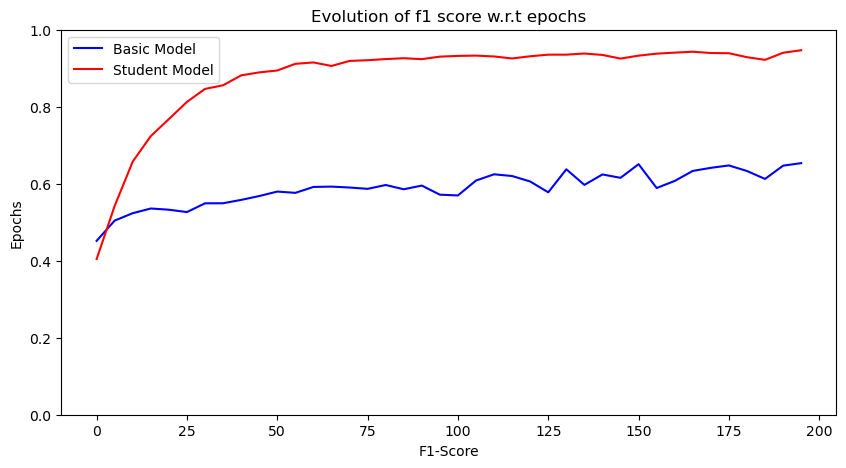

In [18]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()

plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

## **PART 2 : QUESTIONS** (12/20)

There is two types of learning in neural networks:
- Inductive learning: involves learning general rules that can be applied to $\textbf{any}$ unseen data.
- Transductive learning: Transductive learning is a machine learning paradigm where the model is trained on a specific set of labeled data and then applied to a specific set of unlabeled data, with the goal of making predictions for the unlabeled instances. Transductive learning is a special case of inductive learning, with some specificity. For example, the transductive learning focuses on making prediction over a known before-hand test dataset. 



**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

In [ ]:
# Your code goes here

>Answer

1. The transductive architecture proposed in \[1\] is too simple to achieve a proper score. The inductive architecture proposes to implement a pile of three GAT layers, augmented skip connections. The Graph Attentional Layer is more efficient because its attention mechanism grasps better the graph's structure. While convolution operation is borrowed from computer vision community, attention mechanism is more related to Natural Language Processing (NLP).
Hence, it could give is the intuition that graphs are more similar to languages than images. The inherent mechanisms are also quite different. Attentional layer computes coefficients $\alpha_{i,j}$ for each couple $i$ and $j \in \mathcal{N}(i)$, while convolution mixes everything up via a normalized sum, see above. Therefore, the former preserves a more fine-grained relationship between the nodes than the latter. This is certainly a track to follow to prevent over-smoothing.

2. The $F1$ score is defined from precision and recall. Precision and Recall are two classical quantities to measure the performance of a classification task. They are defined as below:
$$
\text{precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}},
$$
and 
$$
\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}.
$$
The precision measures how well the classifier can recover a class when requesting data, it tells if the classifier hallucinates a signifant portion of labels.
The recall measures the effectiveness of the classifier; 
The $F1-$ score is the harmonic mean of those two quantities:
$$
F_1 = \frac{1}{\text{precision}} + \frac{1}{\text{recall}} = 2\frac{\text{precision}\cdot \text{call}}{\text{precision} + \text{call}}
$$

**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ? 
2. Are there solutions to overcome it ? 
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

> Answer

1. Oversmoothing refers to the inherent issue coming along with stacking multiple convolutional layer in a deep neural network. Each layer $l$ aggregates the $l$-th hop neighbors of the nodes, before updating him via a function provided by the operator. While the motivation behind this procedure is to have the neural network understand the graph structure, it can have the mischievous side-effect to average over a too large region, making the nodes indistinguishable. Classifying nodes or applying classification becomes irrelevant in this context. For very deep layers, all the structural information is lost, while relevant information is commonly stored in the structure of the graph, that is the set of graph's edges. A common assumption made is that, assuming edges do not store information, is that, the closer a node is with an other, the more likely the features are to be similar. This phenomenon is called network homophily, and most architectures rely on this hypothesis to make inference.

2. Some solutions are described in \[1\].

3. Whether graph-attention mechanisms counter over-smoothing remains an open-question, see \[2\]. After all, attention mechanism relies on message-passing formalism. The fact that performances surpass what could be observed with convolutional layers feeds our belief that attention mechanism might alleviate feature homogeneization, or at least might appear for deeper neural networks.

## References

\[1\]:  https://arxiv.org/pdf/1710.10903.pdf

\[2\]: https://arxiv.org/pdf/2305.16102